# **DSFM Demo**: Image Recognition - Neural Nets

Creator: [Data Science for Managers - EPFL Program](https://www.dsfm.ch)  
Source:  [https://github.com/dsfm-org/code-bank.git](https://github.com/dsfm-org/code-bank.git)  
License: [MIT License](https://opensource.org/licenses/MIT). See open source [license](LICENSE) in the Code Bank repository. 

-------------

## Overview

In this demo we will perform a common image classification task, using the MNIST dataset. We consider a dataset of hand-written images and we are going to predict the number associated with each image. Every image has a dimension of 28 * 28 pixels and is gray-scale. The input data includes the intensity associated with each pixel row by row, starting from top-left corner (784 pixels in total). The label field shows the number associated with each image. 

The state-of-the-art model achieves an error rate of only 0.23% (Ciresan et al. CVPR 2012). We will achieve an approximate error rate of 1.2% in this demo. 

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-MNIST-Dataset.png" width="700" height="500" align="center"/>


Image source: https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-MNIST-Dataset.png

For an interactive hand-written image classification demo, visit: https://mnist-demo.herokuapp.com/ 

Dataset source: http://yann.lecun.com/exdb/mnist/

## **Part 0**: Setup

In [1]:
# Put all import statements at the top of your notebook

import warnings
warnings.simplefilter('ignore')

# Standard imports
import pandas as pd
import numpy as np
import itertools

# Data science packages
from sklearn.model_selection import learning_curve, validation_curve, StratifiedShuffleSplit, train_test_split, StratifiedKFold
from sklearn.metrics         import confusion_matrix
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression

# Neural networks
from keras.models          import Sequential
from keras.layers          import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.vis_utils import model_to_dot
from keras.models          import Sequential
from keras.layers          import Dense
from keras.utils.np_utils  import to_categorical
from xgboost               import XGBClassifier

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG

%matplotlib inline


Using TensorFlow backend.


In [ ]:
# Set constants 
SCORE    = 'accuracy'
N_CORES  = -1
SEED     =  0
N_SPLITS =  3

In [ ]:
# Define a helper function to facilitate drawing validation and learning curves
def plot_validation_curve(train_scores, cv_scores, x_data, scale='lin', title='', y_label='', x_label=''):
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
    plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)
    
    if (scale == 'lin'):
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    elif (scale == 'log'):
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
# Helper function for plotting confusion matrix 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', 
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
# Define a function to facilitate drawing learning curves
def plot_learning_curve(train_scores,cv_scores,x_data,scale='lin',title='',y_label='',x_label=''):
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
    plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)
    
    if (scale == 'lin'):
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    elif (scale == 'log'):
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

## **Part 1**: Data Preprocessing and EDA

In [2]:
# Load data into a dataframe

data = pd.read_csv('image_data.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Dimensions of data

data.shape

(42000, 785)

In [4]:
# investigate basic statistics of data

data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
# Drop missing value, if any

data.dropna(inplace=True)
data.shape

(42000, 785)

In [6]:
# Separate features and target

target = data['label'].values.ravel()
features = data.iloc[:, 1:].values

In [7]:
# Normalize features to be between 0 and 1

features = features / 255.0

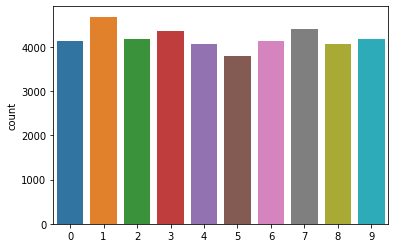

In [8]:
# Check distribution of labels

sns.countplot(target)

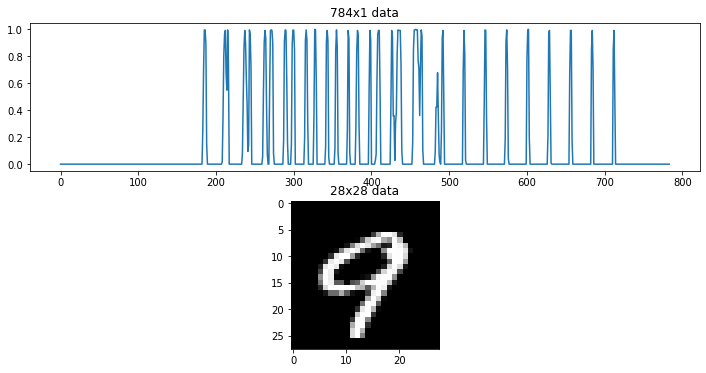

In [9]:
# Visualize values of feature and its visual representation for an arbitrary data point

# Define a subplot with two rows and one column
fig, ax = plt.subplots(2, 1, figsize=(12,6))
dp_id = 100

# Plot features representation in 1D
ax[0].plot(features[dp_id])
ax[0].set_title('784x1 data')

# Plot features representation in 2D
ax[1].imshow(features[dp_id].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

# Show the plot
plt.show()

## **Part 2**: Define Cross-Validation Schema and Dummy Classifier Baseline

In [10]:
# Divide data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=SEED, stratify=target)

In [11]:
# Define a baseline using dummy classifier
# It enables you to define a basic classifier which apply simple strategies such as stratified
# Stratified strategy predicts probability of belonging to positive class as percentage of positive cases

dummy_clf = DummyClassifier(strategy='stratified', random_state = SEED)
dummy_clf.fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)
print('Baseline accuracy: {}'.format(round(baseline_score, 4)))

0.10261904761904762


## **Part 3**: Prediction using Logistic Regression with Ridge regularization

Note: For parameter `C` in `LogisticRegression`, smaller values specify stronger regularization.

We follow the following steps to come up with a prediction model:

1. We tune our model parameter(s) using cross-validation on training set.
2. We fit the model with tuned parameter on training set.
3. We evaluate performance of our model using the test set.

In [12]:
# Define model
model = LogisticRegression(penalty='l2', n_jobs = N_CORES, multi_class='multinomial', solver='saga', random_state=SEED)

# Define cross-validation schema for tuning
cv_schema = StratifiedKFold(n_splits = N_SPLITS, random_state = SEED)

In [13]:
# Tune model against a single hyper parameter C using validation_curve function

tuning_param = 'C'
tuning_param_range = np.logspace(-5, 5, 5)

train_scores_val, cv_scores_val = validation_curve(
    model, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = SCORE, n_jobs = N_CORES)


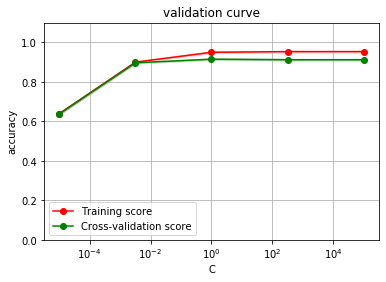

In [14]:
# Plot validation curve
plot_validation_curve(train_scores_val, cv_scores_val, tuning_param_range, scale='log',
                      title='validation curve', y_label='accuracy', x_label='C')

In [15]:
# Obtain the best value of the hyper parameter

best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]

In [16]:
%%time
# Train model with best hyper parameter and assess its performance on the test data
lr_clf = LogisticRegression(C = best_param_val, n_jobs = N_CORES, multi_class='multinomial', solver='saga', random_state=SEED)
lr_clf.fit(X_train,y_train)
lr_score = lr_clf.score(X_test, y_test)
print('LR with Ridge accuracy: {}\n'.format(round(lr_score, 4)))

0.9154761904761904
CPU times: user 2min 27s, sys: 1.9 s, total: 2min 29s
Wall time: 3min 33s


## **Part 4**: Prediction using KNN Classifier

In [17]:
# Set parameters, model and cv schema
model = KNeighborsClassifier(n_jobs = N_CORES)
cv_schema = StratifiedKFold(n_splits = N_SPLITS, random_state = SEED)

In [18]:
%%time
# Tune model against a single hyper parameter

tuning_param = 'n_neighbors'
tuning_param_range = np.array([int(i) for i in np.linspace(5.0, 45.0, 5)])

train_scores_val, cv_scores_val = validation_curve(
    model, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = SCORE, n_jobs = N_CORES)

CPU times: user 1min 6s, sys: 8.64 s, total: 1min 15s
Wall time: 1h 37min 37s


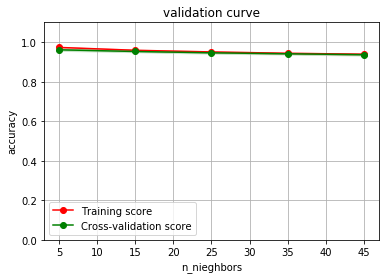

In [19]:
# Plot validation curve
plot_validation_curve(train_scores_val, cv_scores_val, tuning_param_range, scale='lin', 
              title='validation curve', y_label='accuracy', x_label='n_nieghbors')

In [20]:
# Obtain the best value of the hyper parameter

best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]

In [21]:
# Train model with best hyper parameter and assess its performance on test data

knn_clf = KNeighborsClassifier(n_neighbors = best_param_val, n_jobs = N_CORES)
knn_clf.fit(X_train,y_train)
knn_score = knn_clf.score(X_test, y_test)
print('KNN accuracy: {}'.format(round(knn_score, 4)))

0.9663095238095238


## **Part 5**: Prediction using Random Forest

In [22]:
# Set parameters, model and cv schema
model = RandomForestClassifier(n_jobs = N_CORES)
cv_schema = StratifiedKFold(n_splits = N_SPLITS, random_state = SEED)

In [23]:
%%time
# Tune model against a single hyper parameter

tuning_param = 'n_estimators'
tuning_param_range = np.array([int(i) for i in np.linspace(10.0, 80.0, 5)])

train_scores_val, cv_scores_val = validation_curve(
    model, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = SCORE, n_jobs = N_CORES)

CPU times: user 18.7 s, sys: 4.31 s, total: 23 s
Wall time: 36.6 s


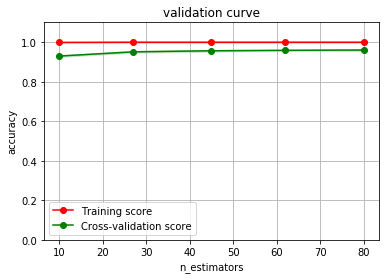

In [24]:
# Plot validation curve

plot_validation_curve(train_scores_val, cv_scores_val, tuning_param_range, scale='lin', 
              title='validation curve', y_label='accuracy', x_label='n_estimators')

In [25]:
# Obtain the best value of the hyper parameter

best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
print(best_param_val)

80


In [26]:
# Train model with best hyper parameter and assess its performance on test data

rf_clf = RandomForestClassifier(n_estimators = best_param_val, n_jobs = n_cores)
rf_clf.fit(X_train,y_train)
rf_score = rf_clf.score(X_test,y_test)
print('RF accuracy: {}'.format(round(rf_score, 4)))

0.96


## **Part 6**: Prediction using Gradient Boosted Trees

In [27]:
# XGboost library has a more performant implementation of gradient boosted trees
model = XGBClassifier(n_jobs = N_CORES, random_state = SEED)
cv_schema = StratifiedKFold(n_splits = N_SPLITS, random_state = SEED)

In [28]:
%%time
# Tune model against a single hyper parameter
tuning_param = 'n_estimators'
tuning_param_range = np.array([int(i) for i in np.linspace(10.0, 50.0, 5)])

train_scores_val, cv_scores_val = validation_curve(
    model, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = SCORE, n_jobs = N_CORES)

CPU times: user 58min 59s, sys: 9.14 s, total: 59min 8s
Wall time: 59min 13s


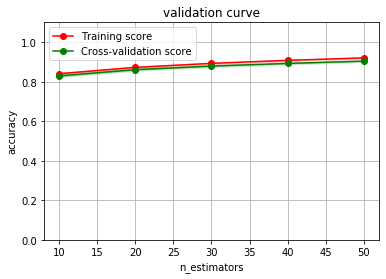

In [29]:
# Plot validation curve
plot_validation_curve(train_scores_val, cv_scores_val, tuning_param_range, scale='lin', 
              title='validation curve', y_label='accuracy', x_label='n_estimators')

In [30]:
# Obtain the best value of the hyper parameter
best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]

In [31]:
# Train model with best hyper parameter and assess its perfrmance on test data

gb_clf = XGBClassifier(n_estimators = best_param_val, n_jobs = N_CORES, random_state=SEED)
gb_clf.fit(X_train, y_train)
gb_score = gb_clf.score(X_test,y_test)
print('Gradient boosted accuracy: {}'.format(round(gb_score, 4)))

0.8991666666666667


## **Part 7**: Prediction using SVC

In [32]:
# Set parameters, model and cv schema
model = SVC(random_state = SEED)
cv_schema = StratifiedKFold(n_splits = N_SPLITS, random_state = SEED)

In [33]:
%%time
# Tune model against a single hyper parameter

tuning_param = 'C'
tuning_param_range = np.logspace(-5, 5, 5)

train_scores_val, cv_scores_val = validation_curve(
    model, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = SCORE, n_jobs = N_CORES)

CPU times: user 222 ms, sys: 243 ms, total: 465 ms
Wall time: 1h 32s


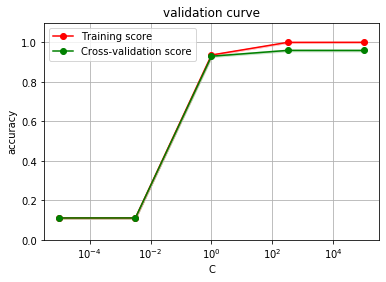

In [34]:
# Plot validation curve

plot_validation_curve(train_scores_val, cv_scores_val, tuning_param_range, scale='log', 
              title='validation curve', y_label='accuracy', x_label='C')

In [35]:
# Obtain the best value of the hyper parameter

best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]

In [36]:
# Train model with increasing amount of training data

svc_clf = SVC(C = best_param_val)
svc_clf.fit(X_train, y_train)
svc_score = svc_clf.score(X_test,y_test)
print('SVC accuracy: {}'.format(round(svc_score, 4)))

0.9630952380952381


## **Part 8**: Prediction using Feed Forward Neural Network

In [37]:
# Encode target labels to one hot vectors (ex : 3 -> [0,0,0,1,0,0,0,0,0,0])

y_train_ohe = to_categorical(y_train, num_classes = 10)
y_test_ohe = to_categorical(y_test, num_classes = 10)
y_train_ohe[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [38]:
# Set parameters, model and cv schema

epochs      = 10  # Number of iterations over full training set
batch_size  = 200 # Number of observations to fit in every batch 
num_pixels  = 28 * 28
num_classes = 10

In [39]:
# Create and compile a simple feed forward neural network

def ffnn_model():
    
    # Create a neural network with two dense layers
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = ffnn_model()

Instructions for updating:
Colocations handled automatically by placer.


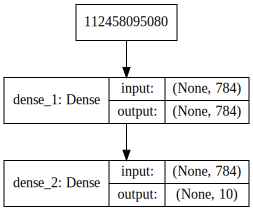

In [40]:
# Visualize keras model
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [41]:
# Fit the model to data

model.fit(X_train, y_train_ohe, validation_data = (X_test, y_test_ohe), 
          epochs = epochs, batch_size = batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 2s 61us/step - loss: 0.3538 - acc: 0.9008 - val_loss: 0.2076 - val_acc: 0.9406
Epoch 2/10
33600/33600 [==============================] - 2s 55us/step - loss: 0.1499 - acc: 0.9577 - val_loss: 0.1469 - val_acc: 0.9567
Epoch 3/10
33600/33600 [==============================] - 2s 54us/step - loss: 0.1001 - acc: 0.9718 - val_loss: 0.1140 - val_acc: 0.9667
Epoch 4/10
33600/33600 [==============================] - 2s 54us/step - loss: 0.0690 - acc: 0.9805 - val_loss: 0.1024 - val_acc: 0.9705
Epoch 5/10
33600/33600 [==============================] - 2s 54us/step - loss: 0.0498 - acc: 0.9863 - val_loss: 0.0920 - val_acc: 0.9717
Epoch 6/10
33600/33600 [==============================] - 2s 54us/step - loss: 0.0361 - acc: 0.9903 - val_loss: 0.0863 - val_acc: 0.9742
Epoch 7/10
33600/33600 [==============================] - 2s 54us/step - loss: 0.

In [42]:
# Get model summary

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Evaluate trained model on test set

ff_loss, ff_score = model.evaluate(X_test, y_test_ohe)
print('Loss: {}'.format(round(ff_loss, 4)))
print('Accuracy: {}'.format(round(ff_score, 4)))

8400/8400 [==============================] - 0s 52us/step
[0.08427780465466812, 0.9753571428571428]
Loss: 0.08427780465466812
Accuracy: 0.9753571428571428


In [45]:
# Get predicted values
predicted_classes = model.predict_classes(X_test)

# Get index of correctly and incorrectly classified observations
target_val_orig = np.argmax(y_test_ohe, 1)

# Get index list of all correctly predicted values
correct_indices = np.nonzero(np.equal(predicted_classes, target_val_orig))[0]

# Get index list of all incorrectly predicted values
incorrect_indices = np.nonzero(np.not_equal(predicted_classes, target_val_orig))[0]

# Print number of correctly and incorrectly clasified observations
print ('Correctly predicted: %i' % np.size(correct_indices))
print ('Incorrectly predicted: %i' % np.size(incorrect_indices))

Correctly predicted: 8193
Incorrectly predicted: 207


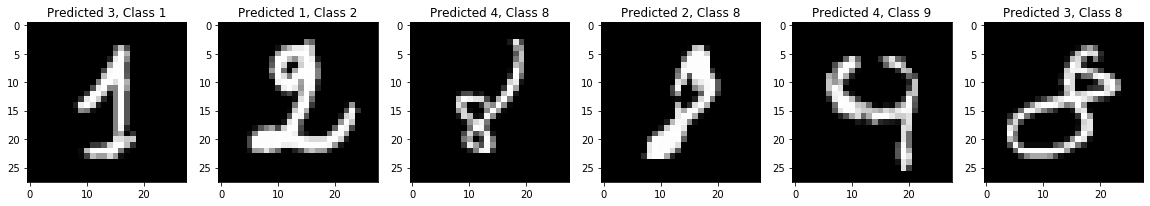

In [46]:
# See a sample of incorrectly classified samples
    
plt.figure(figsize=[20,8])
for i, incorrect in enumerate(incorrect_indices[:6]):
    plt.subplot(1,6,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], target_val_orig[incorrect]))

## **Part 9**: Prediction using Convolutional Neural Network

In [47]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

X_train_reshaped = X_train.reshape(-1,28,28,1)
X_test_reshaped = X_test.reshape(-1,28,28,1)

In [48]:
# Access a single pixel value in reshaped arrays

X_train_reshaped[2800][27][27][0]

0.0

In [49]:
# Encode target labels to one hot vectors

y_train_ohe = to_categorical(y_train, num_classes = 10)
y_test_ohe = to_categorical(y_test, num_classes = 10)

In [50]:
# Set parameters, model and cv schema

epochs     = 10 # number of iterations over full training set
batch_size = 200 # number of observations to fit in every batch 

In [51]:
# Set the CNN architechture (architecture taken from:
# https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

def cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    
    # compile the model
    model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    return (model)

model = cnn_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


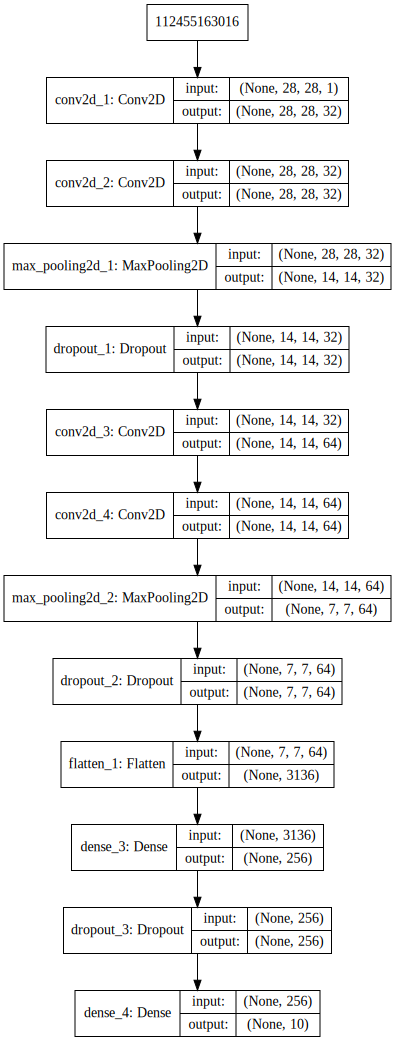

In [52]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [53]:
# Fit the model to data

model.fit(X_train_reshaped, y_train_ohe, validation_data=(X_test_reshaped, y_test_ohe), epochs=epochs, batch_size=batch_size)

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 121s 4ms/step - loss: 0.3892 - acc: 0.8720 - val_loss: 0.0850 - val_acc: 0.9755
Epoch 2/10
33600/33600 [==============================] - 118s 4ms/step - loss: 0.0974 - acc: 0.9699 - val_loss: 0.0533 - val_acc: 0.9826
Epoch 3/10
33600/33600 [==============================] - 121s 4ms/step - loss: 0.0705 - acc: 0.9782 - val_loss: 0.0500 - val_acc: 0.9837
Epoch 4/10
33600/33600 [==============================] - 120s 4ms/step - loss: 0.0541 - acc: 0.9833 - val_loss: 0.0396 - val_acc: 0.9882
Epoch 5/10
33600/33600 [==============================] - 117s 3ms/step - loss: 0.0457 - acc: 0.9859 - val_loss: 0.0407 - val_acc: 0.9890
Epoch 6/10
33600/33600 [==============================] - 115s 3ms/step - loss: 0.0411 - acc: 0.9879 - val_loss: 0.0353 - val_acc: 0.9904
Epoch 7/10
33600/33600 [==============================] - 116s 3ms/step - loss: 0.0366 - acc: 0.9889 - val_loss: 0.0415 - v

In [54]:
# Get model summary

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [55]:
# Evaluate trained model on test set

cnn_loss, cnn_score = model.evaluate(X_test_reshaped, y_test_ohe)
print('Loss: {}'.format(round(cnn_loss, 4)))
print('Accuracy: {}'.format(round(cnn_score, 4)))

8400/8400 [==============================] - 15s 2ms/step
[0.03189456513976482, 0.991547619047619]
Loss: 0.03189456513976482
Accuracy: 0.991547619047619


In [57]:
# Get predicted values
predicted_classes = model.predict_classes(X_test_reshaped)

# Get index of correctly and incorrectly classified observations
target_val_orig = np.argmax(y_test_ohe, 1)

# Get index list of all correctly predicted values
correct_indices = np.nonzero(np.equal(predicted_classes, target_val_orig))[0]

# Get index list of all incorrectly predicted values
incorrect_indices = np.nonzero(np.not_equal(predicted_classes, target_val_orig))[0]

# Print number of correctly and incorrectly clasified observations
print ('Correctly predicted: %i' % np.size(correct_indices))
print ('Incorrectly predicted: %i' % np.size(incorrect_indices))

Correctly predicted: 8329
Incorrectly predicted: 71


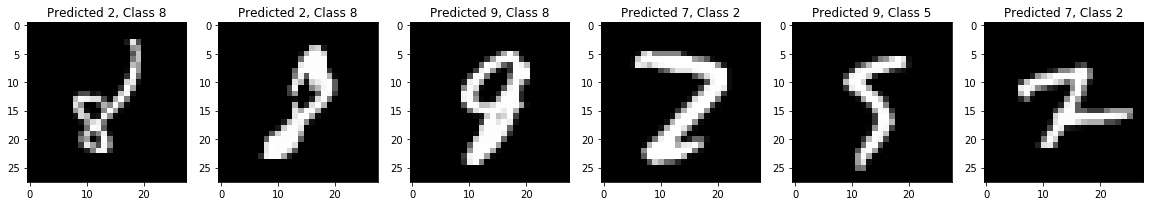

In [58]:
# See a sample of incorrectly classified samples
    
plt.figure(figsize=[20,8])
for i, incorrect in enumerate(incorrect_indices[:6]):
    plt.subplot(1,6,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], target_val_orig[incorrect]))

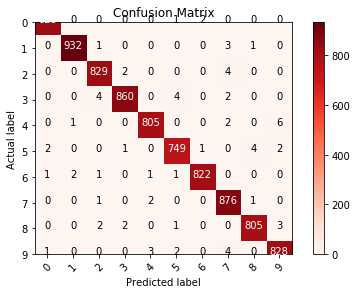

In [59]:
# Look at confusion matrix
y_pred_ohe = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_ohe, axis = 1) 
y_true = np.argmax(y_test_ohe, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## **SUMMARY OF ACCURACY SCORES**

In [ ]:
width    = 35
models   = ['Baseline',     'LR + Ridge', 'KNN',     'Random Forest', 'Boosted Trees', 'SVC',     'NN',     'CNN']
results  = [baseline_score, lr_score,     knn_score, rf_score,        gb_score,        svc_score, ff_score, cnn_score]

print('', '=' * width, '\n', 'Summary of Accuracy Scores'.center(width), '\n', '=' * width)  
for i in range(len(models)):
    print(models[i].center(width-8), '{0:.4f}'.format(round(results[i], 4)))

## **Part 10**: Investment into More Data

In [60]:
# Learning_curve function in sklearn.model_selection is used to assess performance of 
# a model with diferent training sizes, hence justifying possible investments
# into gathering more data

# Here we train random forest classifier with increasing amount of training data
rf_clf      = RandomForestClassifier(n_estimators = 50, n_jobs = N_CORES)
cv_schema   = StratifiedShuffleSplit(n_splits = N_SPLITS, test_size = 0.33, random_state = SEED)
train_sizes = np.linspace(.1, 1.0, 5)

train_sizes, train_scores_learn, cv_scores_learn = learning_curve(
        rf_clf, features, target, cv = cv_schema, n_jobs = N_CORES, train_sizes = train_sizes, scoring = SCORE)

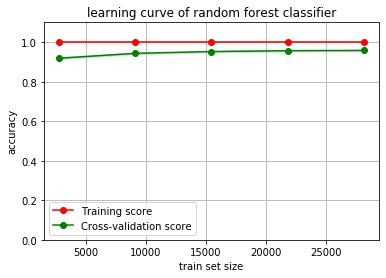

In [62]:
# Plot learning curve

plot_learning_curve(train_scores_learn, cv_scores_learn, train_sizes, scale='lin', 
              title='learning curve of random forest classifier', y_label='accuracy', x_label='train set size')

## **Part 11**: Discussion

* How can one justify the investment on gathering additional data ? 
* How much an accuracy equal to 99.99 % is more significant than one equal to 99.90 % ? 
* What about 99.90 % compared to 99.00 % ?